In [1]:
import sys

sys.path.append('/home/ajliang/search/search')
import argparse
import torch

from utils.common_utils import load_model
from map2map.map2map.data.fields import FieldDataset

In [2]:
"""Load Dataset"""
device = torch.device("cpu")

args = argparse.Namespace(
    init_input_path="/user_data/ajliang/Linear/val/LH0045/4/dis.npy",
    style_path="/user_data/ajliang/Linear/val/LH0045/4/params.npy",
    target_output_path="/user_data/ajliang/Nonlinear/val/LH0045/4/dis.npy",
    load_backward_model_state="/home/ajliang/search/model_weights/backward_model.pt",
    verbose=False,
    dropout_prob=0.0,
    crop=40,
    in_pad=48,
    tgt_pad=48,
)

dataset = FieldDataset(
    style_pattern=args.style_path,
    in_patterns=[args.init_input_path],
    tgt_patterns=[args.target_output_path],
    # in_norms=['cosmology.dis'],
    callback_at='/home/ajliang/search/search/map2map',
    crop=args.crop,
    in_pad=48,
)

In [3]:
crop_index = len(dataset) // 2
data = dataset[crop_index]

In [4]:
input = data['input']
input = input.unsqueeze(0) # add batch dimension
input = input.to(device)
target = data['target']
target = target.unsqueeze(0) # add batch dimension
target = target.to(device)
style = data['style']
style = style.unsqueeze(0) # add batch dimension
style = style.to(device)

In [5]:
args.style_size = dataset.style_size
args.in_chan = dataset.in_chan
args.out_chan = dataset.tgt_chan
backward_model = load_model(args, device=device, path_to_model_state=args.load_backward_model_state)

Loaded model from /home/ajliang/search/model_weights/backward_model.pt, which was trained for 128 epochs.


In [16]:
predicted_input = backward_model(target, style)

In [7]:
import Pk_library as PKL
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_ps_trans_stoc(input, true_input):
    # Setup for plotting power spectrums
    axis = 2
    
    input = input.squeeze(0) # remove batch dimension
    input = input.detach().numpy() # convert to numpy
    true_input = true_input.squeeze(0) # remove batch dimension
    true_input = true_input.detach().numpy() # convert to numpy

    # compute the auto power spectrum of input and true_input and the their cross power spectrum
    xpk = PKL.XPk(
        (input[axis], true_input[axis]),
        BoxSize=1e3/512 * 128,
        axis=0,
        MAS=(None, None)
    )
    wave_num = xpk.k3D
    
    input_power_spec = xpk.Pk[:, 0, 0]
    true_input_power_spec = xpk.Pk[:, 0, 1]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    # plot power spectrum of input and true_input
    ax1.loglog(wave_num, input_power_spec,
            color="orange", label="Learned Linear Input")
    ax1.loglog(wave_num, true_input_power_spec,
            color="blue", label="True Linear Input")
    ax1.set_xlabel("k (log scale)")
    ax1.set_ylabel("P(k) (log scale)")
    ax1.legend()
    ax1.set_title("Power vs Wave Number")

    # plot transfer function fractional errors between input and true_input
    tf_error = np.sqrt(input_power_spec / true_input_power_spec) - 1 # fractional error in transfer function
    ax2.semilogx(wave_num, tf_error, color="red")
    ax2.set_xlabel('k')
    ax2.set_ylabel('Transfer function fractional errors')
    ax2.set_title('Transfer function fractional errors vs k')

    # plot stochasticity
    cross = xpk.XPk[:, 0][:, 0] # cross power spectrum
    stoc = 1 - (cross / np.sqrt(input_power_spec * true_input_power_spec))**2 # stochasticity
    ax3.semilogx(wave_num, stoc, color="green")
    ax3.set_xlabel('k')
    ax3.set_ylabel('1 - (r(k)^2)')
    ax3.set_title('Stochasticty vs k')

    fig.tight_layout()
    plt.show()

In [10]:
true_dataset = FieldDataset(
    style_pattern=args.style_path,
    in_patterns=[args.init_input_path],
    tgt_patterns=[args.target_output_path],
    # in_norms=['cosmology.dis'],
    callback_at='/home/ajliang/search/search/map2map',
    crop=args.crop,
)
true_input = true_dataset[crop_index]['input']
true_input = true_input.unsqueeze(0) # add batch dimension
true_input = true_input.to(device)


Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds


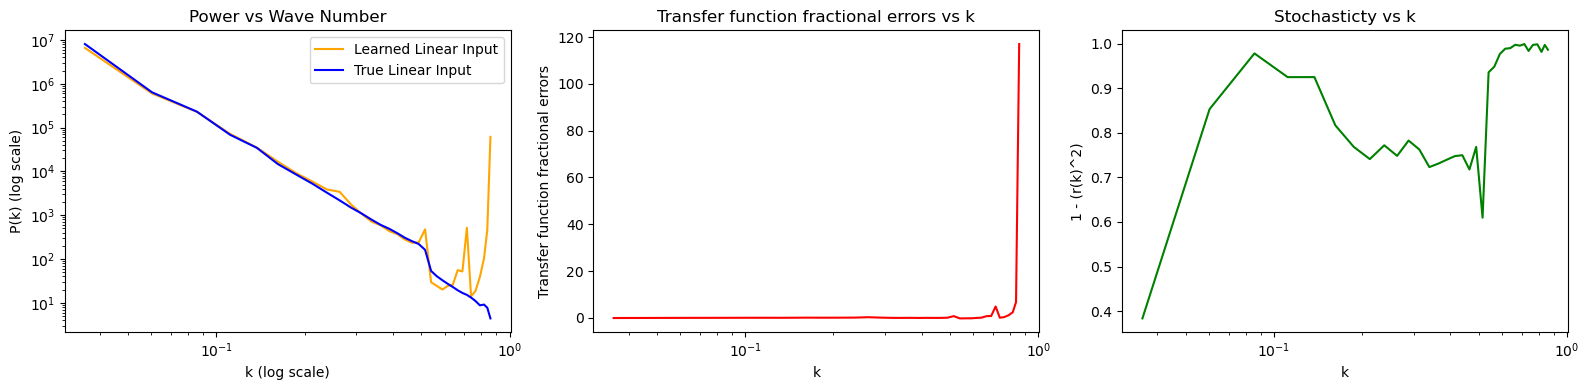

In [17]:
plot_ps_trans_stoc(predicted_input, true_input)

In [15]:
predicted_input.shape

torch.Size([1, 3, 40, 40, 40])

torch.Size([1, 3, 136, 136, 136])

In [27]:
"""Load Dataset"""
device = torch.device("cpu")

args = argparse.Namespace(
    init_input_path="/user_data/ajliang/Linear/val/LH0045/4/dis.npy",
    style_path="/user_data/ajliang/Linear/val/LH0045/4/params.npy",
    target_output_path="/user_data/ajliang/Nonlinear/val/LH0045/4/dis.npy",
    load_backward_model_state="/home/ajliang/search/model_weights/backward_model.pt",
    verbose=False,
    dropout_prob=0.0,
    crop=40,
    in_pad=48,
    tgt_pad=48,
)

forward_dataset = FieldDataset(
    style_pattern=args.style_path,
    in_patterns=[args.init_input_path],
    tgt_patterns=[args.target_output_path],
    # in_norms=['cosmology.dis'],
    callback_at='/home/ajliang/search/search/map2map',
    crop=args.crop,
    in_pad=48,
)


In [30]:
crop_index = 0
data = forward_dataset[crop_index]

input = data['input']
input = input.unsqueeze(0) # add batch dimension
input = input.to(device)
target = data['target']
target = target.unsqueeze(0) # add batch dimension
target = target.to(device)
style = data['style']
style = style.unsqueeze(0) # add batch dimension
style = style.to(device)

In [31]:
input.shape, target.shape, style.shape

(torch.Size([1, 3, 136, 136, 136]),
 torch.Size([1, 3, 40, 40, 40]),
 torch.Size([1, 1]))

In [32]:
backward_dataset = FieldDataset(
    style_pattern=args.style_path,
    in_patterns=[args.init_input_path],
    tgt_patterns=[args.target_output_path],
    # in_norms=['cosmology.dis'],
    callback_at='/home/ajliang/search/search/map2map',
    crop=args.crop,
    tgt_pad=96,
)

In [33]:
backward_data = backward_dataset[crop_index]

backward_target = backward_data['target']
backward_target = backward_target.unsqueeze(0) # add batch dimension
backward_target = backward_target.to(device)
backward_style = backward_data['style']
backward_style = backward_style.unsqueeze(0) # add batch dimension
backward_style = backward_style.to(device)

In [35]:
args.style_size = dataset.style_size
args.in_chan = dataset.in_chan
args.out_chan = dataset.tgt_chan
backward_model = load_model(args, device=device, path_to_model_state=args.load_backward_model_state)

Loaded model from /home/ajliang/search/model_weights/backward_model.pt, which was trained for 128 epochs.


In [37]:
with torch.no_grad():
    predicted_input = backward_model(backward_target, backward_style)

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 3196715008 bytes. Error code 12 (Cannot allocate memory)